In [1]:
import matplotlib
import imageio
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import numpy as np 
import pandas as pd

In [2]:
import os
import re 

files = {os.path.splitext(k)[0]: {} for k in os.listdir('../Practica3/data') if 'acero' in os.path.splitext(k)[0] or 'laton' in os.path.splitext(k)[0]}


for i,file in enumerate(os.listdir('../Practica3/data')):
    name = os.path.splitext(file)[0]
    if 'acero' in name or 'laton' in name:
        f = open(f'../Practica3/data/{file}').read().split()[7:]
        t = [float(f[i]) for i in range(0,len(f),2)]
        v = [float(f[i + 1]) for i in range(0,len(f),2)]
        files[name]['t'] = np.array(t)
        files[name]['v'] = np.array(v)

  

### Acero 3

In [3]:
t = files['laton_3']['t'][1000:]
v = files['laton_3']['v'][1000:]
# arreglo un poco
v = v - np.median(v) #corro el 0
t= np.linspace(0, len(t)/1000, len(t))

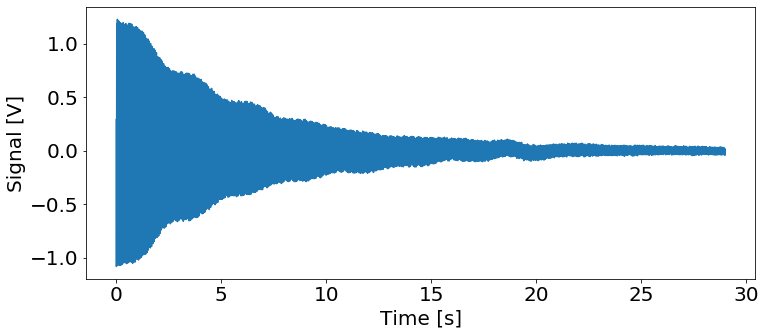

In [4]:
%matplotlib inline
from scipy.signal import find_peaks
plt.figure(figsize = (12,5))
plt.clf()
plt.plot(t,v)

plt.xlabel("Time [s]",fontsize=20)
plt.ylabel("Signal [V]",fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
#plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=14)

Primero vemos qué tipo de ruido es (blanco, rosa), para ver cómo aproximar la frecuencias de modulación

Dos métodos distintos de PSD. PROBARLOS

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.bessel.html

In [5]:
import seaborn as sns
plt.style.use('seaborn-darkgrid')

In [6]:
### Defino variables temporales de la medición.
Fs = 1/t[1]           #[Hz] Frecuencia de muestreo                    
FRef = 33.5         #[Hz] Frecuencia de la referencia: la sacamos del informe
L = len(v);     #[muestras] Longitud de la señal
# Calculamos variables asociadas 
T = 1/Fs;              #[s] Periodo de muestreo
MaxT = L/Fs;           #[s] Tiempo maximo
t = np.linspace(0,L-1,L)*T;         #[s] Time vector
OmegaRef = FRef*2*np.pi;     #[rad/s] frecuencia angular de referencia


#Genero las señales de referencia del lock-in.
Referencia_x=np.array(np.sin(OmegaRef*t));
Referencia_y=np.array(np.cos(OmegaRef*t)); #referencia desfasada en 90º

Muestro la señal del laton en el espacio de frecuencias para ver bien qué otras frecuencias afectan mi medicion

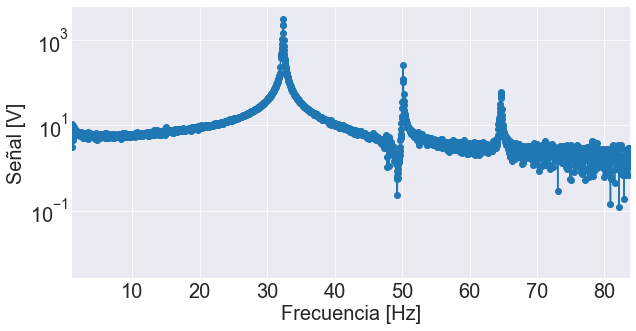

In [7]:
#%% Demodulación lock-in.

# Generamos una figura
plt.figure(figsize=(10,5))
plt.clf()
# Armamos el vector de frecuencias.
freqs=np.fft.fftfreq(L,1/Fs)

# 1 Grafica la FFT de la referencia
fftReferencia= np.abs(np.fft.fft(Referencia_x));
fftSenial= np.abs(np.fft.fft(v));
plt.semilogy(freqs[0:L//2],fftSenial[0:L//2],'o-') 
plt.xlim([1,2.5*FRef])
plt.xlabel("Frecuencia [Hz]",fontsize=20)
plt.ylabel("Señal [V]",fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)

Vemos qué PSD nos da en el tiempo y en elespacio de frecuencia para saber qué frecuencia de corte tomar y qué orden de filtro

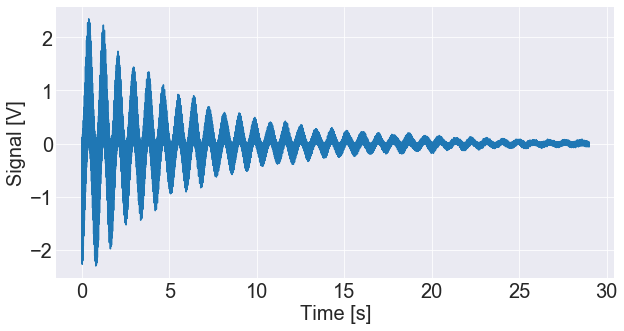

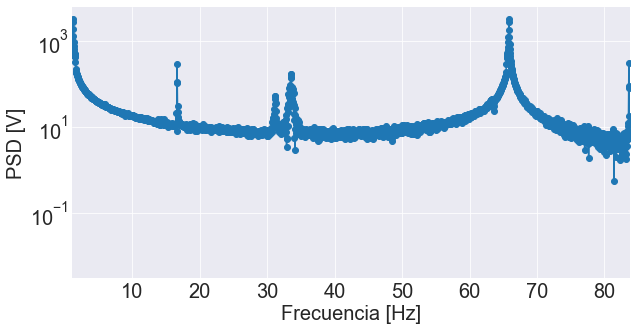

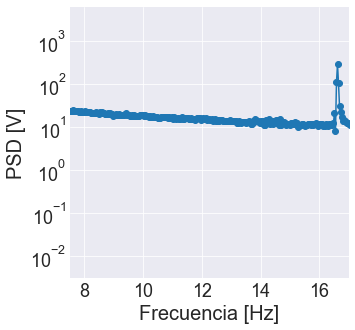

In [9]:
plt.figure(figsize=(10,5))
plt.clf()

# Detección de fase. Multiplicación por referencia
PSDx = 2 * v * Referencia_x;
PSDy = 2 * v * Referencia_y; #PSD del segundo canal
# Graficamos señal multiplicada
plt.plot(t, PSDx, label='Señal')
# ax[0].plot(t, PSDy, label='Señal')
plt.xlabel('Tiempo [s]')
plt.ylabel('PSD [V]')
plt.xlabel("Time [s]",fontsize=20)
plt.ylabel("Signal [V]",fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)


plt.figure(figsize=(10,5))
plt.clf()
# Grafica la FFT de la señal multiplicada
fftPSDx= np.abs(np.fft.fft(PSDx));
fftPSDy= np.abs(np.fft.fft(PSDy));
plt.semilogy(freqs[0:L//2],fftPSDx[0:L//2],'o-')
plt.xlim([1,2.5*FRef])
plt.xlabel("Frecuencia [Hz]",fontsize=20)
plt.ylabel("PSD [V]",fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)


plt.figure(figsize=(5,5))
plt.clf()
# Grafica la FFT de la señal multiplicada
fftPSDx= np.abs(np.fft.fft(PSDx));
fftPSDy= np.abs(np.fft.fft(PSDy));
plt.semilogy(freqs[0:L//2],fftPSDx[0:L//2],'o-')
plt.xlim([7.5,17])
plt.xlabel("Frecuencia [Hz]",fontsize=20)
plt.ylabel("PSD [V]",fontsize=20)
plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=18)
                
                


necesito fijar la frecuencia de corte antes de 15Hz para no obtener el ruido de esa frecuencia

In [11]:
# Elección de tiempo caracteríscito y orden del filtro
fc=1      #[Hz] Frecuencia de corte
orden = 6; # Orden del filtro.


grafico la señal despues del filtro pasabajo con el filtro BESSEL

(Text(0, 0.5, 'Salida'), None)

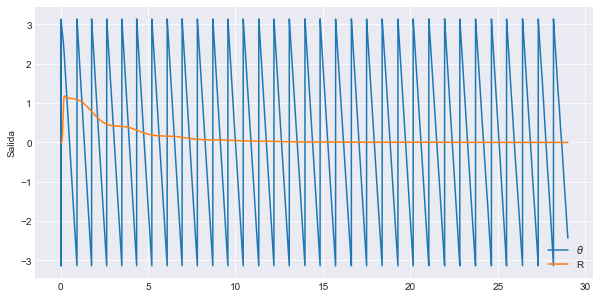

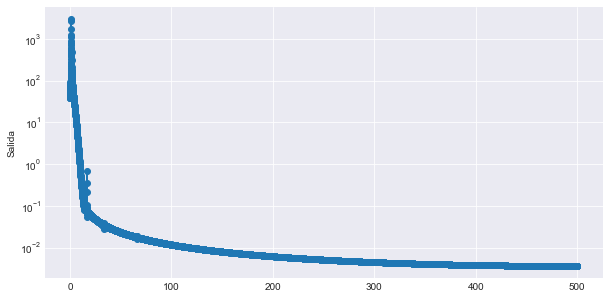

In [18]:
plt.figure(figsize=(10,5))
plt.clf()
# Filtrado de señal 
sos = signal.bessel(orden, 2*np.pi*fc, 'low', fs=Fs,output='sos') # Generación de parametros del filrado
PSDxFiltrada= signal.sosfilt(sos,PSDx) # Filtrado
PSDyFiltrada= signal.sosfilt(sos,PSDy) # Filtrado


## Para graficar R y theta
plt.plot(t,np.arctan2(PSDyFiltrada,PSDxFiltrada,), label=r'$\theta$')
plt.plot(t,PSDxFiltrada**2+PSDyFiltrada**2,label='R') #ESTO TENEMOS QUE AJUSTAR
## Para graficar X e Y
#ax[3].plot(t,PSDxFiltrada,label='X')
#ax[3].plot(t,PSDyFiltrada,label='Y')
plt.legend(loc='lower right')
plt.ylabel('Salida')


plt.figure(figsize=(10,5))
plt.clf()
# 4 Grafica la FFT de la señal demodulada
fftPSDxFiltrada= np.abs(np.fft.fft(PSDxFiltrada));
fftPSDyFiltrada= np.abs(np.fft.fft(PSDyFiltrada));
plt.semilogy(freqs[0:L//2],fftPSDxFiltrada[0:L//2],'o-') 
plt.ylabel('Salida'),ax[1].grid(True)


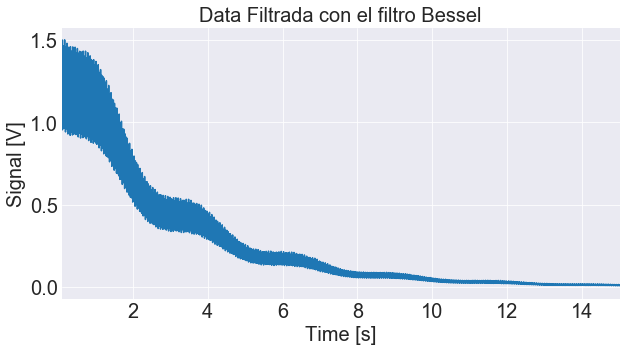

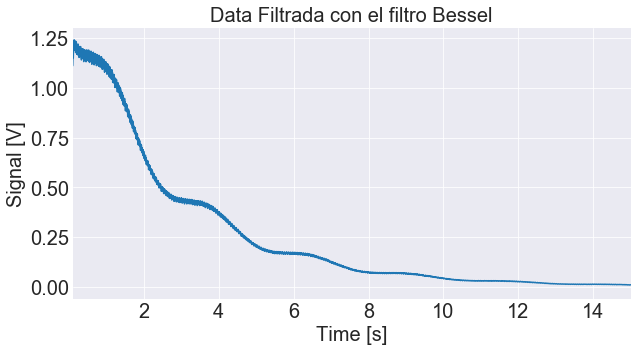

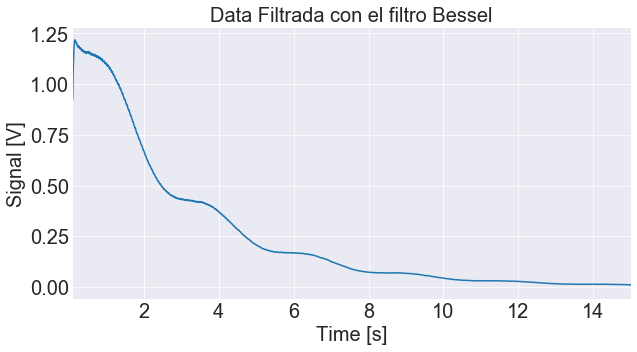

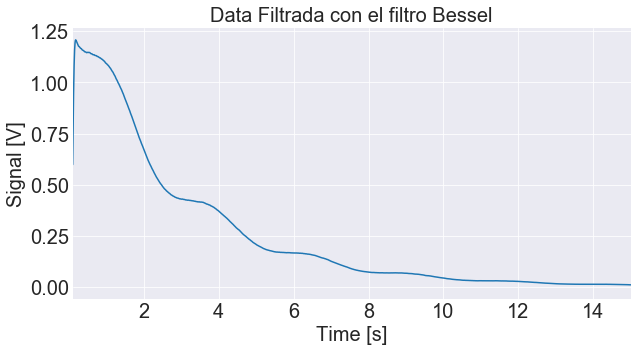

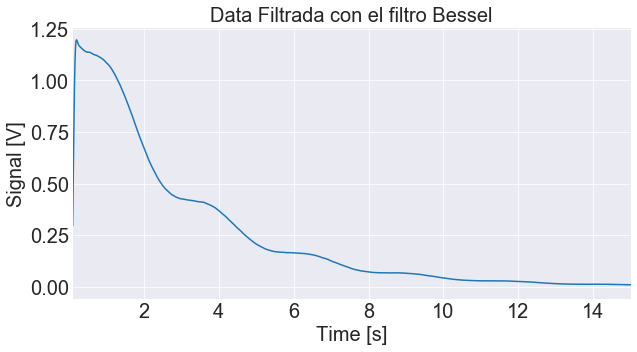

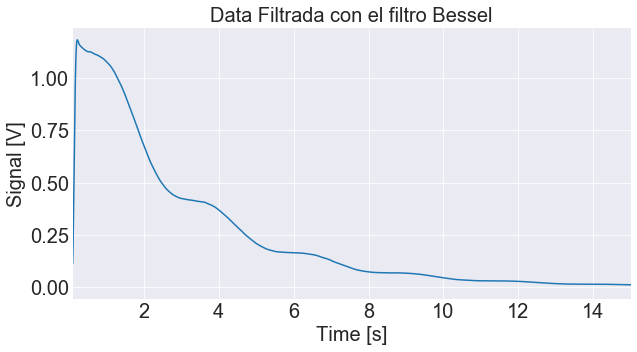

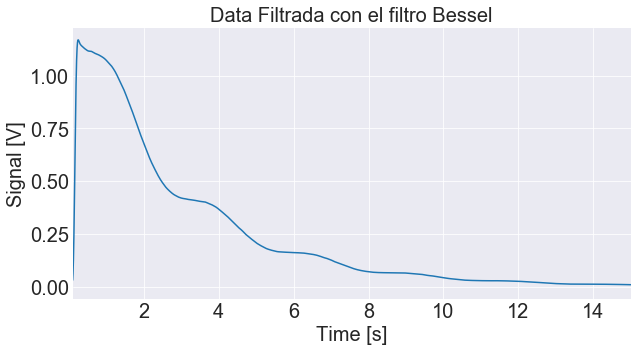

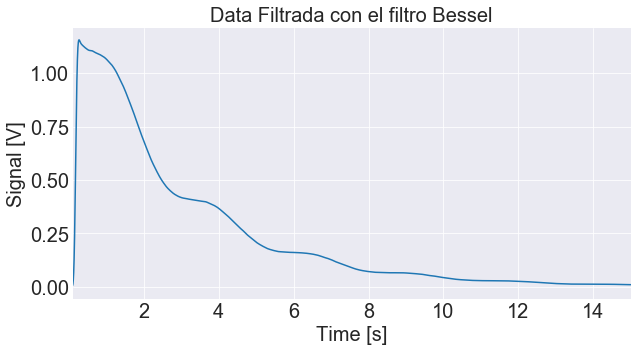

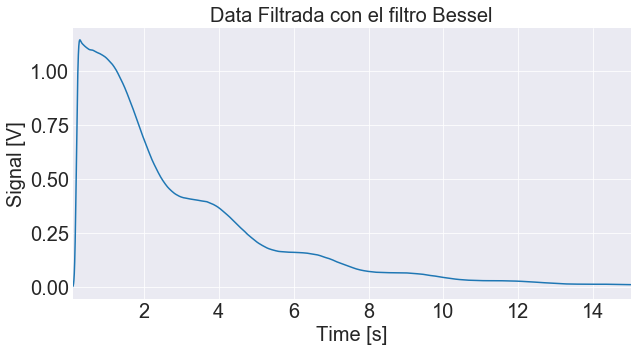

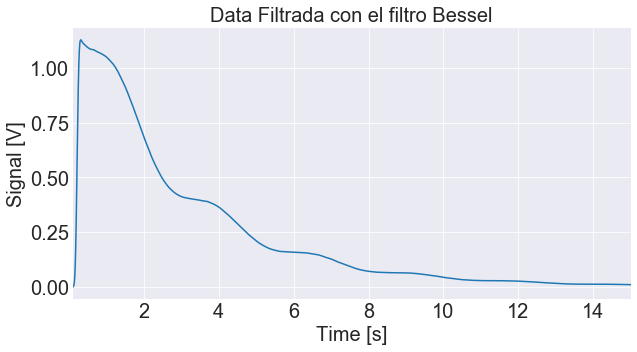

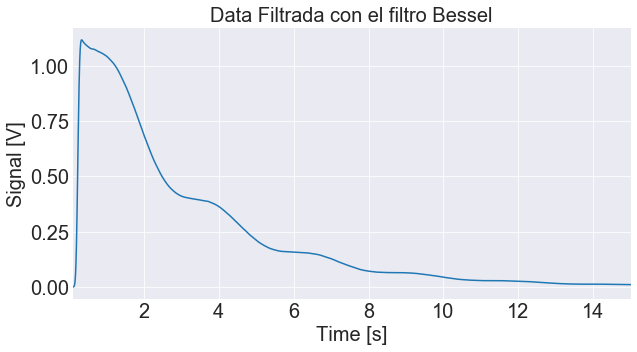

In [55]:


for i in range(1,12):
    plt.figure(figsize=(10,5))
    plt.clf()
    # Filtrado de señal 
    sos = signal.bessel(i, 2*np.pi*1, 'low', fs=Fs,output='sos') # Generación de parametros del filrado
    PSDxFiltrada= signal.sosfilt(sos,PSDx) # Filtrado
    PSDyFiltrada= signal.sosfilt(sos,PSDy) # Filtrado


    ## Para graficar R y theta
    #plt.plot(t,np.arctan2(PSDyFiltrada,PSDxFiltrada,), label=r'$\theta$')
    plt.plot(t,PSDxFiltrada**2+PSDyFiltrada**2,label='R') #ESTO TENEMOS QUE AJUSTAR
    plt.xlim([0.1,15])
    ## Para graficar X e Y
    #ax[3].plot(t,PSDxFiltrada,label='X')
    #ax[3].plot(t,PSDyFiltrada,label='Y')
    plt.title(f'Data Filtrada con el filtro Bessel',fontsize=20)
    plt.ylabel('Salida')
    plt.xlabel("Time [s]",fontsize=20)
    plt.ylabel("Signal [V]",fontsize=20)
    plt.tick_params(axis="x", labelsize=20)
    plt.tick_params(axis="y", labelsize=20)


In [57]:
len(sos)

6

grafico la señal despues del filtro pasabajo con el filtro BUTTERWORTH

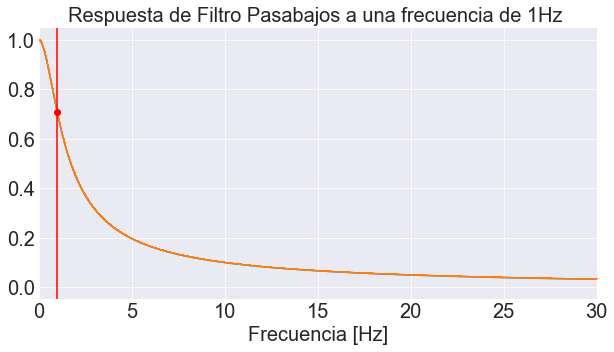

In [84]:
from scipy.signal import butter, lfilter, freqz, bessel

fs = 33.5*2*np.pi
nyq = 0.5 * fs
cutoff = 1
normal_cutoff = cutoff / nyq
b, a = bessel(1, normal_cutoff, btype='low', analog=False)
b2, a2 = butter(1, normal_cutoff, btype='low', analog=False)
# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
w2, h2 = freqz(b2, a2, worN=8000)
plt.figure(figsize=(10,5))
plt.plot(0.5*fs*w/np.pi, np.abs(h),label='Bessel',marker=",")
plt.plot(0.5*fs*w2/np.pi, np.abs(h2), label='Butterworth',marker=",")
plt.plot(1, 0.5*np.sqrt(2), 'ko',color='red')
plt.axvline(1, color='red')
plt.xlim(0, 30)
plt.title("Respuesta de Filtro Pasabajos a una frecuencia de 1Hz ",fontsize=20)
plt.xlabel('Frecuencia [Hz]',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)


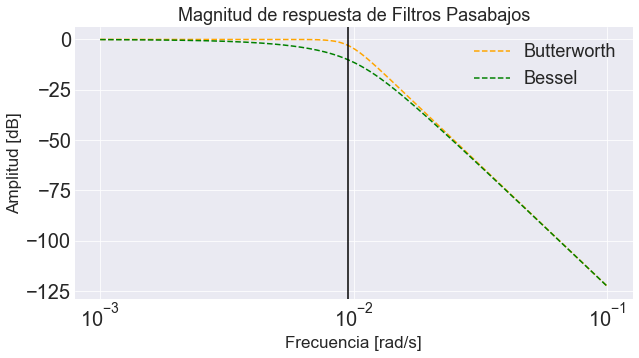

In [112]:
plt.figure(figsize=(10,5))
fs = 33.5*2*np.pi
nyq = 0.5 * fs
cutoff = 1
normal_cutoff = cutoff / nyq
b, a = signal.butter(6, normal_cutoff, 'low', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(np.abs(h)), color='orange', ls='dashed',label='Butterworth')
b, a = signal.bessel(6, normal_cutoff, 'low', analog=True, norm='phase')
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(np.abs(h)), color='green', ls='dashed',label='Bessel')
plt.title('Magnitud de respuesta de Filtros Pasabajos',fontsize=18)
plt.xlabel('Frecuencia [rad/s]',fontsize=17)
plt.ylabel('Amplitud [dB]',fontsize=17)
plt.locator_params(axis='x', numticks=10)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.axvline(normal_cutoff, color='black')
plt.legend(fontsize=18)
plt.show()